In [1]:
import torch
import torch.nn as nn
import numpy as np
import csv
%load_ext autotime

time: 287 µs (started: 2020-12-31 20:40:09 -05:00)


# Load Data

In [2]:
def load_data(filename):
    reader = csv.reader(open(filename, 'r'), delimiter= ",")
    
    NNin = []
    NNout = []

    for line in reader:
        count=0
        states = []
        for field in line:
            if (count!=4):
                states.append(np.float(field))
            else:
                NNout.append(np.float(field))
            count +=1
        NNin.append(states)
    return NNin,NNout
    

time: 824 µs (started: 2020-12-31 20:40:10 -05:00)


In [3]:
filename='NNdataMPC.csv'
data1, labels1 = load_data(filename)
filename='NNdataMPC.csv'
data2, labels2 = load_data(filename)


time: 170 ms (started: 2020-12-31 20:40:11 -05:00)


In [4]:
print('Input1 Dimensions : ', np.shape(data1))
print('Output1 Dimensions : ', np.shape(labels1))
print('Input2 Dimensions : ', np.shape(data2))
print('Output2 Dimensions : ', np.shape(labels2))


Input1 Dimensions :  (15000, 4)
Output1 Dimensions :  (15000,)
Input2 Dimensions :  (15000, 4)
Output2 Dimensions :  (15000,)
time: 37.9 ms (started: 2020-12-31 20:40:11 -05:00)


In [5]:
data = np.concatenate((data1,data2), axis=0)
labels = np.concatenate((labels1,labels2), axis=0)

N = np.size(labels)
labels=np.reshape(labels,[N, 1])
print('Input Dimensions : ', np.shape(data))
print('Output Dimensions : ', np.shape(labels))

Input Dimensions :  (30000, 4)
Output Dimensions :  (30000, 1)
time: 34 ms (started: 2020-12-31 20:40:11 -05:00)


In [6]:
from sklearn.model_selection import train_test_split


X_train1, X_test1, y_train1, y_test1 = train_test_split(data, labels, test_size=0.04, random_state=42)

time: 871 ms (started: 2020-12-31 20:40:11 -05:00)


In [7]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=0.05, random_state=42)

time: 4.27 ms (started: 2020-12-31 20:40:12 -05:00)


In [8]:
print('Train Data Dimensions : ', np.shape(X_train1))
print('Val Data Dimensions : ', np.shape(X_val1))
print('Test Data Dimensions : ', np.shape(X_test1))



Train Data Dimensions :  (27360, 4)
Val Data Dimensions :  (1440, 4)
Test Data Dimensions :  (1200, 4)
time: 1.02 ms (started: 2020-12-31 20:40:13 -05:00)


In [9]:
X_train = torch.tensor(X_train1, dtype=torch.float) # 15k x 4 tensor
y_train = torch.tensor(y_train1, dtype=torch.float) # 15k, tensor
X_val = torch.tensor(X_val1, dtype=torch.float) # 15k x 4 tensor
y_val = torch.tensor(y_val1, dtype=torch.float) # 15k, tensor
X_test = torch.tensor(X_test1, dtype=torch.float) # 15k x 4 tensor
y_test = torch.tensor(y_test1, dtype=torch.float) # 15k, tensor
print(X_train.size())
print(y_train.size())

torch.Size([27360, 4])
torch.Size([27360, 1])
time: 14.2 ms (started: 2020-12-31 20:40:14 -05:00)


# Model

In [10]:
import torch.optim as optim

class NN_MPC(nn.Module):
    def __init__(self, config):
        super(NN_MPC, self).__init__()
        self.inputSize = config["input_dim"]
        self.outputSize = config["output_dim"]
        self.hiddenSize1 = config["hidden1"] 
        self.hiddenSize2 = config["hidden2"] 
        self.alpha = config["learning_rate"]
        self.h=torch.tensor(config["input_uper_bound"]+1., dtype=torch.float)
        self.f0=config["f0"]
        self.N = config["N"]
        
        self.h1 = nn.Linear(self.inputSize, self.hiddenSize1)
        #self.d1 = nn.Dropout(p=0.2)
        self.h2 = nn.Linear(self.hiddenSize1,self.hiddenSize2)
        #self.d2 = nn.Dropout(p=0.5)
        self.h3 = nn.Linear(self.hiddenSize2,1)
    def forward(self,x):
        x = torch.sigmoid(self.h1(x))
        #x = self.d1(x)
        x = torch.tanh(self.h2(x))
        #x = self.d2(x)
        x = self.h3(x)
        #print(x)
        return x



time: 1.18 ms (started: 2020-12-31 20:40:16 -05:00)


# Parameters

In [28]:
config= {"input_lower_bound": -4.0,
         "input_uper_bound": np.reshape(4.0,[1,1]),
         "input_dim":np.shape(data)[1],
         "output_dim":1,
         "hidden1": 17,
         "hidden2": 12,
         "mu": 0,
         "sigma_2":1,
         "learning_rate":0.001,
         "f0":1.,
         "N": np.shape(data)[0],
         "batch_size" : 8000,
         "epochs": 300,
         "iters": 10
         
    }
NN = NN_MPC(config)



time: 1.28 ms (started: 2020-12-31 20:51:31 -05:00)


In [21]:
lr = config["learning_rate"]

criterion = nn.MSELoss()
#optimizer = optim.SGD(NN.parameters(), lr=lr, momentum=0.9)

optimizer = optim.Adam(NN.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.0, amsgrad=False)

time: 666 µs (started: 2020-12-31 20:47:03 -05:00)


# Model

In [22]:
N= np.shape(X_train1)[0]
epochs = config["epochs"]
batch_size = config["batch_size"]
iters = 100#int(N/batch_size)#config["iters"]
loss_val = 50000.0
val_dim = np.size(y_val)
display_interval = 100
i=0
while loss_val>1e-2 and i<int(display_interval*100):
    i+=1
    #print(N)
    running_loss =0.0
    permutation = torch.randperm(X_train.size()[0])

    for j in range(iters):
        optimizer.zero_grad()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        # in case you wanted a semi-full example
        outputs = NN.forward(batch_x)
        #outputs = NN(X_train[j])
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    
    if i % display_interval == 0:    # print every display_interval=100 mini-batches
        outval = NN.forward(X_val)
        lossv = criterion(outval, y_val)
        loss_val = lossv.item()
        print('iter : ',int(i/display_interval),'\t train loss :'+"{:.3f}".format(running_loss/iters),
             '\t val loss :'+"{:.4f}".format(loss_val))
        running_loss = 0.0
            

iter :  1 	 train loss :0.064 	 val loss :0.0507
time: 37.6 s (started: 2020-12-31 20:47:08 -05:00)


In [30]:
outputs = NN(X_test)
loss = criterion(outputs, y_test)
print('Test loss : ', loss.item())
print(outputs[0:10],'\n', y_test[0:10])

Test loss :  0.015143156051635742
tensor([[ 1.1824e-02],
        [ 9.9929e-03],
        [ 1.7040e-03],
        [-2.7939e+00],
        [-1.6091e+00],
        [ 5.1194e-02],
        [ 3.9193e+00],
        [ 1.6845e-03],
        [ 1.5362e-03],
        [ 1.7441e-03]], grad_fn=<SliceBackward>) 
 tensor([[ 1.2316e-02],
        [-3.2720e-03],
        [-2.2740e-06],
        [-2.7094e+00],
        [-1.6992e+00],
        [ 4.1938e-02],
        [ 4.0000e+00],
        [-7.3462e-05],
        [ 2.3417e-04],
        [ 4.2021e-06]])
time: 25.5 ms (started: 2020-12-31 20:51:40 -05:00)


In [ ]:
#torch.save(NN.state_dict(), 'MPC_model_weights')


In [29]:
NN.load_state_dict(torch.load('MPC_model_weights'))

<All keys matched successfully>

time: 9.85 ms (started: 2020-12-31 20:51:34 -05:00)


In [ ]:
NN.eval()

# Cartpole

In [36]:
import matplotlib.pyplot as plt
import time
%matplotlib inline
import pylab as pl
from IPython import display


time: 1.12 ms (started: 2020-12-31 20:52:28 -05:00)


In [32]:
def rotate_pos(pos, angle):

    rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle), np.cos(angle)]])
    #print(np.shape(np.dot(pos, rot_mat.T)))
    return np.dot(pos, rot_mat.T)

def square(center_x, center_y, shape, angle):

    #square_xy = np.array([shape[0], shape[1]])
    square_xy = np.array([[shape[0], shape[1]],
                              [-shape[0], shape[1]],
                              [-shape[0], -shape[1]],
                              [shape[0], -shape[1]],
                              [shape[0], shape[1]]])
    # translate position to world
    # rotation
    trans_points = rotate_pos(square_xy, angle)
    # translation
    trans_points += [center_x, center_y]

    return trans_points[:,0], trans_points[:,1]

def coord_cartpole(curr_q,config):

    cart = config["cart"]
    l=config["l"]
    #cart
    cart_x,cart_y = square(curr_q[0], 0., cart, 0.)
    #pend
    pend_x = [curr_q[0], curr_q[0]+l*np.cos(curr_q[2]-np.pi/2)]
    pend_y = [0., l*np.sin(curr_q[2]-np.pi/2)]
    return cart_x,cart_y, pend_x, pend_y





time: 1.42 ms (started: 2020-12-31 20:52:14 -05:00)


In [33]:
config2 = {"l": 1, # length of the pendulum
         "mp": 0.2, # mass of the pendulum
         "Mc": 1, # Mass of the cart
         "g": 9.81, # gravity
         "dt":0.09, # time step for MPC
         "Np": 22, #Horizn length
         "cart" : (0.6,0.2), # dimensions of the cart
         "iters" : 150, # Maximum number of iteration for the solution
         "q11": 12., # state coefficient diag_1
         "q22": 0.09, # diag_2
         "q33": 2., # diag_3
         "q44": 0.1, # diag_3
         "R" : 0.3 # Input Coefficient
         }
def state(curr_q,u,config):
    mp = config["mp"]
    l = config["l"]
    Mc = config["Mc"]
    g = config["g"]
    dt = config["dt"]
    
    #state x
    dq1 = curr_q[1]  # initial state of the cartpole
    # state xdot
    dq2 = (u+mp*np.sin(curr_q[2])*(l*(curr_q[3]**2)
                                          +g*np.cos(curr_q[2])))/(Mc+mp*(np.sin(curr_q[2])**2))
    # state theta
    dq3 = curr_q[3]
    # state thetadot
    dq4 = (-u*np.cos(curr_q[2])-mp*l*(curr_q[3]**2)
               *np.cos(curr_q[2])*np.sin(curr_q[2])
               -(Mc+mp)*g*np.sin(curr_q[2]))/(l*(Mc+mp*
                                                (np.sin(curr_q[2])**2)))
    next_q = curr_q+np.array([dq1,dq2,dq3,dq4])*dt
    for i in range(np.size(next_q)):
        try:
            np.dtype(next_q[i])
        except:
            next_q[i]=next_q[i][0]
    return next_q

time: 2.28 ms (started: 2020-12-31 20:52:15 -05:00)


In [34]:
max_iter=400
old_q = np.array([0., 0., -np.random.randn(1)[0], 0.])
old_q = torch.tensor(np.reshape(old_q,[1,4]),dtype=torch.float)
old_q1=old_q.detach().numpy()[0]
history_q = [old_q1]
for i in range(max_iter):
    
    u = NN.forward(old_q)
    u = u.detach().numpy()
    u = u[0]

    
    curr_q = np.array(state(old_q1,u,config2)).astype(float)
    
    history_q.append(curr_q)
    old_q=torch.tensor(curr_q,dtype=torch.float)
    
    old_q1=old_q.detach().numpy()



    


time: 103 ms (started: 2020-12-31 20:52:17 -05:00)


/Users/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


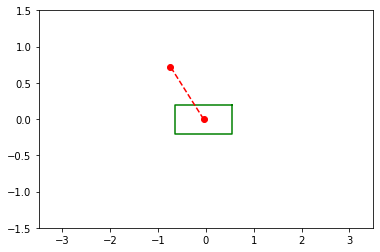

time: 1min (started: 2020-12-31 20:52:32 -05:00)


In [37]:
for i in range(max_iter):
    curr_x = history_q[i]
    x1,y1, x2, y2 = coord_cartpole(curr_x,config2)
    pl.clf()
    pl.plot(x1, y1, 'g-',x2, y2, 'r--o')
    pl.xlim(-3.5, 3.5)
    pl.ylim(-1.5,1.5)
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(0.00006)

In [ ]:
x=[]
xdot=[]
th=[]
thdot=[]
for i in range(max_iter):
    x.append(history_q[i][0])
    xdot.append(history_q[i][1])
    th.append(history_q[i][2])
    thdot.append(history_q[i][3])
 

plt.plot(x)
plt.plot(xdot)
plt.plot(th)
plt.plot(thdot)
plt.legend(['x','xdot','theta','thetadot'])